In [1]:
import numpy as np
from math import cos, pi
import matplotlib.pyplot as plt
%matplotlib notebook

# Generate textfile

In [2]:
#Comment this line if you don't want to generate a new text file
%run generate_text.py -n 160 -o resources/text.txt

# Get text form file

In [3]:
path_text = "resources/text.txt"
with open(path_text, "r") as file:
        text = file.read()
print(text)


0*,\2mphIeghSuHtn"$+Y`84BJ`>ie#!_,Lv$JGYpUNtwR"ZC|z}%tbwrg!*:REIJ'Vp't_js/TpMz_vP4<nZ8~qp_<SJj9%'VQLBEKXw`|)(uvIL{(=AVGtg<dmV[$_A@G51EN<5kh*U8brx(EaU94^jB`hI`kB


# Convert text to binary

In [4]:
barker = [1,1,1,1,1,0,0,1,1,0,1,0,1]
EOT = [0,0,0,0,1,0,0]


def to_binary(text):
    """
    Convert the text to a binary array. Each character is converted
    to its ASCII binary representation. 13-Length barker code are
    appended at the beginning and the end of the signal.
    
    :param text: string containing the text we want to send
    :return binary: numpy array containing the binary form of the text
    """
    binary = barker[:]

    for c in text:
        ascii_val = ord(c)
        bits = bin(ascii_val)[2:]
        padding = "0"*(7-len(bits))
        bits = padding + bits
        bits = [int(b) for b in bits]
        binary.extend(bits)
    
    binary.extend(EOT)
    binary = np.array(binary)

    return binary

In [5]:
binary_text_with_barker = to_binary(text)
binary_text = binary_text_with_barker[len(barker):]
print(str(len(binary_text)), "bits must be sent with", str(len(barker)), "bits for the synchronization, total:", str(len(binary_text_with_barker)))

1127 bits must be sent with 13 bits for the synchronization, total: 1140


# Convert binary to waveform

In [6]:
Fs = 22050
nbr_sample = 100
t = np.arange(nbr_sample)
f00 = 2000
f01 = 4000
f10 = 6000
f11 = 8000

In [7]:
def base0(t):
    """
    Basis for the 0-bit
    """
    return 0.5*(cos(2*pi*f00*t/Fs)+cos(2*pi*f01*t/Fs))

def base1(t):
    """
    Basis for the 1-bit
    """
    return 0.5*(cos(2*pi*f10*t/Fs)+cos(2*pi*f11*t/Fs))

def bit_to_wave(b):
    """
    Converts one bit to its signal form sampled between 0 and 100/Fs
    
    :param b: the bit we want to convert
    :return: the sampled signal corresponding either to base0 or base1
    """
    if b == 0:
        f = np.vectorize(base0)
        return f(t)
    elif b == 1:
        f = np.vectorize(base1)
        return f(t)

signals = bit_to_wave(binary_text_with_barker[0])
for b in binary_text_with_barker[1:]:
    signals = np.hstack((signals, bit_to_wave(b)))

In [8]:
barker_wave = signals[:nbr_sample*len(barker)]
barker_wave_length = barker_wave.size

signal_path = "resources/signal.txt"
np.savetxt(signal_path, signals)

# Send signal to the server

In [9]:
%run pdc_project_channel_access/client.py --input_file=resources/signal.txt --output_file=resources/recv.txt --srv_hostname=iscsrv72.epfl.ch --srv_port=80

print("Siganl saved at recv.txt")

Siganl saved at recv.txt


# Load signal from file

In [10]:
recv_path = "resources/recv.txt"
filtered_signal = np.loadtxt(recv_path)

# Synchronization

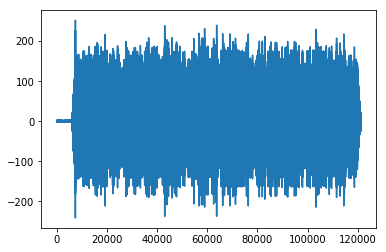

In [11]:
threshold = 50

#compute autocorrelation
auto = np.correlate(filtered_signal, barker_wave, mode='same')

plt.figure("Correlation between received signal and barker code signal")
plt.plot(auto)
plt.show()

#Find first peak
first_peak = np.argwhere(auto > threshold)[0,0]
end = first_peak+2*barker_wave_length
#Find peak of the windowed correlation to get the beginning of the signal
xd = np.argmax(auto[:end]) + barker_wave_length//2
filtered_signal = filtered_signal[xd:]


# Decode

In [12]:
def signal_to_binary(filtered_signal):
    """
    Decode the signal
    """
    nbr_chars = filtered_signal.size//nbr_sample

    bits = []
    for i in range(nbr_chars):
        s = filtered_signal[i*nbr_sample:(i+1)*nbr_sample]
        fft = np.fft.fft(s)
        b = 0 if np.argmax(fft)*Fs/nbr_sample < 5000 else 1
        bits.append(b)
    return bits

In [13]:
decoded_binary = signal_to_binary(filtered_signal)

# Convert binary back to text

In [14]:
def get_chunks(decoded_binary):
    """
    Convert the decoded binary into a list of chunks of 7 bits
    corresponding to the ASCII character
    """
    bits = []
    for i in range(0, len(decoded_binary), 7):
        if decoded_binary[i:i+7] == EOT:
            return i, bits
        bits.append(decoded_binary[i:i+7])

def binary_to_text(bits):
    """
    Convert the chunks of bits into a string
    """
    bits = [''.join([str(b) for b in bs]) for bs in bits]
    return bits

In [15]:
i, chunks = get_chunks(decoded_binary)
decoded_binary = decoded_binary[:i+7]
decoded_text = binary_to_text(chunks)
decoded_text = [chr(int(x,2)) for x in decoded_text]
recovered_text = ''.join(decoded_text)
print(recovered_text)

0*,\2mphIeghSuHtn"$+Y`84BJ`>ie#!_,Lv$JGYpUNtwR"ZC|z}%tbwrg!*:REIJ'Vp't_js/TpMz_vP4<nZ8~qp_<SJj9%'VQLBEKXw`|)(uvIL{(=AVGtg<dmV[$_A@G51EN<5kh*U8brx(EaU94^jB`hI`kB


# Compute error rate

In [16]:
nbr_error = np.sum(np.abs(np.array(decoded_binary)-binary_text))
error_rate = nbr_error/len(decoded_binary)
print(error_rate)

0.0
